In [130]:
from IPython import display
from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l

npx.set_np()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [131]:
X, y = next(iter(train_iter))
image = X[0][0]
image_height = image.shape[0] # 28
image_width = image.shape[1] # 28

num_inputs = image_width * image_height # 784
num_outputs = len(set(y.tolist())) # 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
W.attach_grad()
b.attach_grad()

In [132]:
X = np.array(
    [
        [1.0, 2.0, 3.0],
        [4.0, 5.0, 6.0]
    ]
)
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(array([[5., 7., 9.]]),
 array([[ 6.],
        [15.]]))

In [133]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

In [134]:
X = np.random.normal(0, 1, (2, 5))
X_prob = softmax(X)
print(f'See our original values have negatives:\n{X}')
print(f'then after softmax the values are normalized to be between 0 and 1:\n{X_prob}')
print(f'AND they are now probablities that sum to 1:\n{X_prob.sum(1)}')

See our original values have negatives:
[[-0.07759447  0.7080753  -0.21224867  0.24281053  0.04880929]
 [-2.4971173  -1.8657326   0.6601476   0.9496234  -0.97501695]]
then after softmax the values are normalized to be between 0 and 1:
[[0.1519683  0.33339956 0.13282305 0.20936453 0.17244455]
 [0.01603434 0.03014796 0.3769066  0.5034444  0.07346675]]
AND they are now probablities that sum to 1:
[1. 1.]


In [135]:
def net(X):
    return softmax(np.dot(X.reshape((-1, num_inputs)), W) + b)

In [136]:
y = np.array([0, 2])
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

array([0.1, 0.5])

In [137]:
def cross_entropy(y_hat, y):
    return -np.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

array([2.3025851, 0.6931472])

In [138]:
def accuracy(y_hat, y): #@save
    """Compute the number of correct prediction"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(cmp.astype(y.dtype).sum())

In [139]:
accuracy(y_hat, y) / len(y)

0.5

In [140]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [141]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

In [142]:
evaluate_accuracy(net, test_iter)

0.1008

In [143]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """Train a model within one epoch (defined in Chapter 3)."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        # Compute gradients and update parameters
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [144]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [145]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(0, train_metrics + (test_acc,))
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [146]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

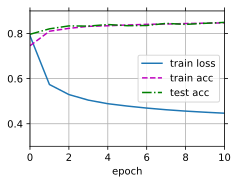

In [147]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)